In [1]:
#!pip install --upgrade protobuf==3.20.0
!pip install -U 'tensorflow[and-cuda]'

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 20.1 MB/s eta 0:00:0000:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.0/5.0 MB 101.3 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 296.8/296.8 MB 6.3 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 96.2 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 620.6/620.6 MB 3.2 MB/s eta 0:00:00:00:0100:01
  Attempting uninstall: nvidia-nccl-cu12
    Found existing installation: nvidia-nccl-cu12 2.21.5
    Uninstalling nvidia-nccl-cu12-2.21.5:
      Successfully uninstalled nvidia-nccl-cu12-2.21.5
  Attempting uninstall: ml_dtypes
    Found existing installation: ml-dtypes 0.4.1
    Uninstalling ml-dtypes-0.4.1:
      Successfully uninstalled ml-dtypes-0.4.1
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.18.0
    Uninstalling tensorboard-2.18.0:
      Successfully uninstalled tensorboard-2.18.0
  Attempting uninstall: keras
  

In [2]:
!pip install evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.7/47.7 MB 42.5 MB/s eta 0:00:00:00:0100:01
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 19.0.1
    Uninstalling pyarrow-19.0.1:
      Successfully uninstalled pyarrow-19.0.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 2.12.0 requires google-cloud-bigquery-storage<3.0.0,>=2.30.0, which is not installed.
pylibcudf-cu12 25.2.2 requires pyarrow<20.0.0a0,>=14.0.0; platform_machine == "x86_64", but you have pyarrow 22.0.0 which is incompatible.
cudf-cu12 25.2.2 requires pyarrow<20.0.0a0,>=14.0.0; platform_machine == "x86_64", but you have pyarrow 22.0.0 which is incompatible.
bigframes 2.12.0 requires rich<14,>=12.4.4, but you have rich 14.2.0 which is incompatible.
cudf-polars-cu12 25.6.0 requires pyli

# **1.   Imports**

In [3]:
import torch
import gc
import random
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import evaluate
import time
import glob
from typing import Dict, Any, List, Optional, Tuple, cast
from dataclasses import dataclass, asdict

# Hugging Face Libraries
from datasets import load_dataset, DatasetDict
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer,
    DataCollatorWithPadding,
    EvalPrediction
)
from peft import LoraConfig, TaskType, get_peft_model

In [4]:
# Hardware & Reproducibility
SEED = 42
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

In [5]:
# Data & Model Settings
MODEL_NAME = "distilbert-base-uncased"
TRAIN_SAMPLE_SIZE = 3000
NUM_LABELS = 6
MAX_LENGTH = 128

In [6]:
# PSO Settings
PSO_POPULATION_SIZE = 20   # Number of particles
PSO_EPOCHS = 5            # Number of iterations
INERTIA_W = 0.7           # Inertia weight
COGNITIVE_C1 = 1.5        # Personal best weight
SOCIAL_C2 = 1.5           # Global best weight

In [7]:
# Search Space (Discrete Options)
WARMUP_OPTIONS = [0.0, 0.06, 0.1]
RANK_OPTIONS = [2, 4, 8, 16, 24]
ALPHA_OPTIONS = [8, 16, 32, 64, 96]
DROPOUT_OPTIONS = [0.0, 0.05, 0.1, 0.2]
TARGET_MODULE_OPTIONS = [
    ["q_lin", "v_lin"],                           # Index 0
    ["q_lin", "v_lin", "ffn.lin1", "ffn.lin2"]    # Index 1
]

# **2.   Data Structure Definitions**

In [8]:
@dataclass(frozen=True)
class LoraHyperparameters:
    """Structure to hold a specific set of hyperparameters"""
    learning_rate: float
    warmup_ratio: float
    rank: int
    alpha: int
    dropout: float
    target_modules: List[str]

class Particle:
    """Represents a single particle in the swarm"""
    def __init__(self, dim, min_bound, max_bound):
        self.position = np.random.uniform(min_bound, max_bound, dim)
        self.velocity = np.random.uniform(-1, 1, dim)
        self.best_position = np.copy(self.position)
        self.best_score = -float('inf') # Maximizing accuracy

# **3.   Helper Functions**

In [9]:
def set_global_seed(seed: int):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)

def cleanup_memory():
    """Forcefully releases GPU memory"""
    torch.cuda.empty_cache()
    gc.collect()

# **4.   Data Management Loss**

In [10]:
class DataManager:
    def __init__(self, model_name: str = MODEL_NAME):
        self.tokenizer = AutoTokenizer.from_pretrained(model_name)
        self.dataset: Optional[Dict[str, Any]] = None

    def prepare_data(self) -> Dict[str, Any]:
        if self.dataset is not None:
            return self.dataset

        print("Loading and processing data...")
        full_dataset = cast(DatasetDict, load_dataset("dair-ai/emotion"))

        # Consistent subset selection
        train_subset = full_dataset["train"].shuffle(seed=SEED).select(range(TRAIN_SAMPLE_SIZE))

        def _tokenize(examples):
            return self.tokenizer(
                examples["text"],
                truncation=True,
                padding="max_length",
                max_length=MAX_LENGTH
            )

        tokenized_train = train_subset.map(_tokenize, batched=True)
        tokenized_val = full_dataset["validation"].map(_tokenize, batched=True)
        tokenized_test = full_dataset["test"].map(_tokenize, batched=True)

        self.dataset = {
            "train": tokenized_train,
            "validation": tokenized_val,
            "test": tokenized_test,
            "tokenizer": self.tokenizer,
            "num_labels": NUM_LABELS
        }
        print("Data preparation complete.")
        return self.dataset

# **5.   PSO Optimiser Engine**

In [11]:
class PSO_HyperparameterOptimizer:
    def __init__(self, data_bundle: Dict[str, Any]):
        self.data = data_bundle
        self.results: List[Dict[str, Any]] = []
        self.metric = evaluate.load("accuracy")

        # 6 Dimensions: [LR, Warmup, Rank, Alpha, Dropout, Modules]
        # We use indices for discrete lists, continuous for LR
        self.min_bounds = np.array([1e-5, 0, 0, 0, 0, 0], dtype=float)
        self.max_bounds = np.array([
            2e-4,
            len(WARMUP_OPTIONS) - 0.01,
            len(RANK_OPTIONS) - 0.01,
            len(ALPHA_OPTIONS) - 0.01,
            len(DROPOUT_OPTIONS) - 0.01,
            len(TARGET_MODULE_OPTIONS) - 0.01
        ], dtype=float)
        self.dim = 6
        self.best_params = None
        self.best_val_accuracy = -1.0

    def _map_position_to_params(self, position: np.ndarray) -> LoraHyperparameters:
        """Maps continuous particle position to discrete hyperparameters"""
        # Clip to ensure bounds
        pos = np.clip(position, self.min_bounds, self.max_bounds)

        return LoraHyperparameters(
            learning_rate=float(pos[0]),
            warmup_ratio=WARMUP_OPTIONS[int(pos[1])],
            rank=RANK_OPTIONS[int(pos[2])],
            alpha=ALPHA_OPTIONS[int(pos[3])],
            dropout=DROPOUT_OPTIONS[int(pos[4])],
            target_modules=TARGET_MODULE_OPTIONS[int(pos[5])]
        )

    def _compute_metrics(self, eval_pred: EvalPrediction):
        preds, labels = eval_pred
        preds = np.argmax(preds, axis=1)
        return self.metric.compute(predictions=preds, references=labels)

    def train_model(self, trial_id: int, params: LoraHyperparameters) -> float:
        """Runs a single training trial"""
        print(f"   > Params: LR={params.learning_rate:.2e}, Rank={params.rank}, Alpha={params.alpha}")
        
        model = AutoModelForSequenceClassification.from_pretrained(
            MODEL_NAME, num_labels=self.data["num_labels"]
        )

        peft_config = LoraConfig(
            task_type=TaskType.SEQ_CLS,
            r=params.rank,
            lora_alpha=params.alpha,
            lora_dropout=params.dropout,
            target_modules=params.target_modules
        )
        model = get_peft_model(model, peft_config)

        current_seed = SEED + trial_id
        
        args = TrainingArguments(
            output_dir=f"./results/trial_{trial_id}",
            learning_rate=params.learning_rate,
            per_device_train_batch_size=16,
            per_device_eval_batch_size=16,
            num_train_epochs=3,
            warmup_ratio=params.warmup_ratio,
            weight_decay=0.01,
            eval_strategy="epoch",
            save_strategy="no",
            logging_strategy="epoch",
            seed=current_seed,
            report_to="none",
            load_best_model_at_end=False
        )

        data_collator = DataCollatorWithPadding(tokenizer=self.data["tokenizer"])

        trainer = Trainer(
            model=model,
            args=args,
            train_dataset=self.data["train"],
            eval_dataset=self.data["validation"],
            data_collator=data_collator,
            compute_metrics=self._compute_metrics
        )

        trainer.train()
        eval_results = trainer.evaluate()

        # Clean up immediately
        del model
        del trainer
        cleanup_memory()

        return eval_results["eval_accuracy"]

    def evaluate_on_test(self, params: LoraHyperparameters, trial_id: int) -> float:
        """Evaluates best hyperparameters on the test set"""
        print(f"\n   > Evaluating on TEST set with params: LR={params.learning_rate:.2e}, Rank={params.rank}")

        model = AutoModelForSequenceClassification.from_pretrained(
            MODEL_NAME, num_labels=self.data["num_labels"]
        )

        peft_config = LoraConfig(
            task_type=TaskType.SEQ_CLS,
            r=params.rank,
            lora_alpha=params.alpha,
            lora_dropout=params.dropout,
            target_modules=params.target_modules
        )
        model = get_peft_model(model, peft_config)

        args = TrainingArguments(
            output_dir=f"./results/test_eval_{trial_id}",
            learning_rate=params.learning_rate,
            per_device_train_batch_size=16,
            per_device_eval_batch_size=16,
            num_train_epochs=3,
            warmup_ratio=params.warmup_ratio,
            weight_decay=0.01,
            eval_strategy="no",
            save_strategy="no",
            logging_strategy="no",
            seed=SEED + trial_id,
            report_to="none",
        )

        data_collator = DataCollatorWithPadding(tokenizer=self.data["tokenizer"])

        trainer = Trainer(
            model=model,
            args=args,
            train_dataset=self.data["train"],
            eval_dataset=self.data["test"],
            data_collator=data_collator,
            compute_metrics=self._compute_metrics
        )

        # Train on training data
        trainer.train()

        # Evaluate on test data
        test_results = trainer.evaluate()

        del model
        del trainer
        cleanup_memory()

        return test_results["eval_accuracy"]

    def evaluate_top_solutions_with_seeds(self, run_id=1, num_top=5, num_seeds=3):
        """
        Retrains the top 5 unique configs found in PSO 3 times each with NEW seeds.
        Saves the results to 'robustness_results_runX.csv'.
        """
        print(f"\n{'='*60}")
        print(f"ROBUSTNESS CHECK: TOP {num_top} CONFIGS x {num_seeds} NEW SEEDS")
        print(f"{'='*60}")

        # 1. Filter Top Unique Candidates
        sorted_results = sorted(self.results, key=lambda x: x['val_accuracy'], reverse=True)
        unique_candidates = []
        seen_configs = set()

        for res in sorted_results:
            config_key = (
                res['learning_rate'], res['warmup_ratio'], res['rank'], 
                res['alpha'], res['dropout'], tuple(res['target_modules'])
            )
            if config_key not in seen_configs:
                seen_configs.add(config_key)
                unique_candidates.append(res)
            if len(unique_candidates) >= num_top:
                break

        final_robust_results = []
        
        # 2. Retrain Candidates
        for rank, candidate in enumerate(unique_candidates, 1):
            params = LoraHyperparameters(
                learning_rate=candidate['learning_rate'],
                warmup_ratio=candidate['warmup_ratio'],
                rank=candidate['rank'],
                alpha=candidate['alpha'],
                dropout=candidate['dropout'],
                target_modules=candidate['target_modules']
            )

            print(f"\n--- Rank {rank} (Original Acc: {candidate['val_accuracy']:.4%}) ---")
            seed_accuracies = []

            for seed_i in range(num_seeds):
                robust_trial_id = 10000 + (run_id * 100) + seed_i

                display_seed = SEED + robust_trial_id
                
                print(f"   > Retraining Seed {seed_i + 1}/{num_seeds} (Seed: {display_seed})...", end=" ", flush=True)
                
                acc = self.train_model(robust_trial_id, params)
                
                seed_accuracies.append(acc)
                print(f"Acc: {acc:.4%}")

            mean_acc = np.mean(seed_accuracies)
            std_acc = np.std(seed_accuracies)

            # Prepare Record for CSV
            record = asdict(params)
            record.update({
                'rank': rank,
                'original_pso_accuracy': candidate['val_accuracy'],
                'mean_robust_accuracy': mean_acc,
                'std_robust_accuracy': std_acc,
                'seed_accuracies': str(seed_accuracies)
            })
            final_robust_results.append(record)

        # 3. Save Robustness Results to CSV
        robust_df = pd.DataFrame(final_robust_results)
        robust_filename = f"robustness_results_run{run_id+1}.csv"
        robust_df.to_csv(robust_filename, index=False)
        print(f"\nRobustness detailed results saved to {robust_filename}")

        # 4. Update Best Params based on MEAN accuracy (Stability wins)
        final_robust_results.sort(key=lambda x: x['mean_robust_accuracy'], reverse=True)
        if final_robust_results:
            winner = final_robust_results[0]
            print(f"\nUpdated Best Params to Rank {winner['rank']} (Mean: {winner['mean_robust_accuracy']:.4%})")
            
            self.best_params = LoraHyperparameters(
                learning_rate=winner['learning_rate'],
                warmup_ratio=winner['warmup_ratio'],
                rank=winner['rank'],
                alpha=winner['alpha'],
                dropout=winner['dropout'],
                target_modules=winner['target_modules']
            )
            self.best_val_accuracy = winner['mean_robust_accuracy']
            
    def run_optimization(self):
        print(f"Starting PSO: {PSO_POPULATION_SIZE} particles, {PSO_EPOCHS} epochs.")
        swarm = [Particle(self.dim, self.min_bounds, self.max_bounds) for _ in range(PSO_POPULATION_SIZE)]
        global_best_pos = np.zeros(self.dim)
        global_best_score = -float('inf')
        trial_count = 0

        for epoch in range(PSO_EPOCHS):
            print(f"\n=== PSO EPOCH {epoch + 1}/{PSO_EPOCHS} ===")
            for i, particle in enumerate(swarm):
                trial_count += 1
                # print(f"\n[Trial {trial_count}] Particle {i+1}")
                try:
                    params = self._map_position_to_params(particle.position)
                    start_time = time.time()
                    accuracy = self.train_model(trial_count, params)
                    duration = time.time() - start_time
                    
                    print(f"   > [Trial {trial_count}] Accuracy: {accuracy:.4%}, Time: {duration:.2f}s")

                    if accuracy > particle.best_score:
                        particle.best_score = accuracy
                        particle.best_position = np.copy(particle.position)

                    if accuracy > global_best_score:
                        global_best_score = accuracy
                        global_best_pos = np.copy(particle.position)
                        print(f"   >>> New Swarm Best: {accuracy:.4%}")

                    record = asdict(params)
                    record.update({
                        "trial_id": trial_count, 
                        "val_accuracy": accuracy, 
                        "pso_epoch": epoch+1,
                        "training_time_sec": duration
                    })
                    self.results.append(record)

                except Exception as e:
                    print(f"!!! ERROR in Trial {trial_count}: {e}")
                    cleanup_memory()

            # Update Particles
            for particle in swarm:
                r1, r2 = np.random.rand(self.dim), np.random.rand(self.dim)
                vel_cognitive = COGNITIVE_C1 * r1 * (particle.best_position - particle.position)
                vel_social = SOCIAL_C2 * r2 * (global_best_pos - particle.position)
                particle.velocity = (INERTIA_W * particle.velocity) + vel_cognitive + vel_social
                particle.position += particle.velocity
                particle.position = np.clip(particle.position, self.min_bounds, self.max_bounds)

    def save_results(self, filename: str):
        if not self.results:
            print("No results to save.")
            return
        df = pd.DataFrame(self.results)
        df.to_csv(filename, index=False)
        print(f"Results saved to {filename}")
        
        best_run = df.loc[df['val_accuracy'].idxmax()]
        print("\nBEST VALIDATION RESULT:")
        print(f"Accuracy: {best_run['val_accuracy']:.4%}")
        
        print(f"Rank: {best_run['rank']}, Alpha: {best_run['alpha']}, LR: {best_run['learning_rate']:.2e}")

# **6.   Main Execution Pipeline**

In [12]:
def run_single_optimization(run_id: int, data_bundle: Dict[str, Any]) -> Tuple[float, float, LoraHyperparameters]:
    print(f"\n{'='*60}\nRUN {run_id + 1}\n{'='*60}")

    optimizer = PSO_HyperparameterOptimizer(data_bundle)

    # 1. Broad Search (20 particles)
    optimizer.run_optimization()

    optimizer.evaluate_top_solutions_with_seeds(run_id=run_id, num_top=5, num_seeds=3)
    
    # 3. Save PSO History
    optimizer.save_results(f"initial_results.csv")
    
    # 4. Final Test (Using the Robust Best Params)
    print("\n" + "="*50 + "\nEVALUATING ROBUST BEST CONFIG ON TEST SET\n" + "="*50)
    test_accuracy = optimizer.evaluate_on_test(optimizer.best_params, trial_id=run_id)
    print(f"\nRun {run_id + 1} - Robust Val: {optimizer.best_val_accuracy:.4%}, Test: {test_accuracy:.4%}")

    return optimizer.best_val_accuracy, test_accuracy, optimizer.best_params

if __name__ == "__main__":
    NUM_RUNS = 1  # Number of independent optimization runs
    STOCHASTICITY_SEED_BASE = SEED

    print("="*60)
    print(f"STOCHASTICITY REPORTING: {NUM_RUNS} FULL OPTIMIZATION RUN")
    print("="*60)

    all_results = []
    val_accuracies = []
    test_accuracies = []

    try:
        # 1. Prepare Data (once, reused for all runs)
        data_mgr = DataManager(MODEL_NAME)
        data_bundle = data_mgr.prepare_data()

        for run in range(NUM_RUNS):
            set_global_seed(STOCHASTICITY_SEED_BASE + run)

            try:
                val_acc, test_acc, best_params = run_single_optimization(run, data_bundle)

                all_results.append({
                    "run_id": run + 1,
                    "seed": STOCHASTICITY_SEED_BASE + run,
                    "val_accuracy": val_acc,
                    "test_accuracy": test_acc,
                    "learning_rate": best_params.learning_rate,
                    "warmup_ratio": best_params.warmup_ratio,
                    "rank": best_params.rank,
                    "alpha": best_params.alpha,
                    "dropout": best_params.dropout,
                    "target_modules": str(best_params.target_modules)
                })

                val_accuracies.append(val_acc)
                test_accuracies.append(test_acc)

            except Exception as e:
                print(f"!!! ERROR in Run {run + 1}: {e}")
                import traceback
                traceback.print_exc()
                cleanup_memory()

        # 3. Print Summary Statistics
        print("\n" + "="*60)
        print("STOCHASTICITY SUMMARY")
        print("="*60)

        if val_accuracies:
            val_mean = np.mean(val_accuracies)
            val_std = np.std(val_accuracies)
            val_min = np.min(val_accuracies)
            val_max = np.max(val_accuracies)

            print(f"\nVALIDATION ACCURACY (from PSO search):")
            print(f"  Mean: {val_mean:.4%}")
            print(f"  Std:  {val_std:.4%}")
            print(f"  Min:  {val_min:.4%}")
            print(f"  Max:  {val_max:.4%}")

            test_mean = np.mean(test_accuracies)
            test_std = np.std(test_accuracies)
            test_min = np.min(test_accuracies)
            test_max = np.max(test_accuracies)

            print(f"\nTEST ACCURACY (generalization):")
            print(f"  Mean: {test_mean:.4%}")
            print(f"  Std:  {test_std:.4%}")
            print(f"  Min:  {test_min:.4%}")
            print(f"  Max:  {test_max:.4%}")

            print(f"\nIndividual Results:")
            for result in all_results:
                print(f"  Run {result['run_id']}: Val={result['val_accuracy']:.4%}, Test={result['test_accuracy']:.4%}")

        # 4. Save stochasticity results
        results_df = pd.DataFrame(all_results)
        results_df.to_csv("pso_stochasticity_results.csv", index=False)
        print(f"\nStochasticity results saved to pso_stochasticity_results.csv")

        # Print Final Summary
        print("\n" + "="*60)
        print("FINAL SINGLE RUN SUMMARY")
        print("="*60)
        
        if all_results:
            res = all_results[0]
            print(f"Run 1 Results:")
            print(f"  Robust Validation Accuracy: {res['val_accuracy']:.4%}")
            print(f"  Final Test Accuracy:        {res['test_accuracy']:.4%}")
            print(f"  Best Parameters Found:")
            print(f"    LR: {res['learning_rate']:.2e}, Rank: {res['rank']}, Alpha: {res['alpha']}")

        # 4. Save results
        results_df = pd.DataFrame(all_results)
        results_df.to_csv("pso_final_results.csv", index=False)
        print(f"\nFinal results saved to pso_final_results.csv")
    
    except KeyboardInterrupt:
        print("\nOptimization interrupted by user.")
    except Exception as e:
        print(f"\nCritical failure: {e}")
        import traceback
        traceback.print_exc()
    finally:
        cleanup_memory()
        print("Process Complete.")

STOCHASTICITY REPORTING: 1 FULL OPTIMIZATION RUN


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Loading and processing data...


README.md: 0.00B [00:00, ?B/s]

split/train-00000-of-00001.parquet:   0%|          | 0.00/1.03M [00:00<?, ?B/s]

split/validation-00000-of-00001.parquet:   0%|          | 0.00/127k [00:00<?, ?B/s]

split/test-00000-of-00001.parquet:   0%|          | 0.00/129k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/16000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/3000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Data preparation complete.

RUN 1


Starting PSO: 20 particles, 5 epochs.

=== PSO EPOCH 1/5 ===
   > Params: LR=8.12e-05, Rank=16, Alpha=32


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
No label_names provided for model class `PeftModelForSequenceClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,1.575000,1.338386,0.527500
2,1.162500,1.052251,0.613000
3,0.995900,0.987069,0.648000


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


   > [Trial 1] Accuracy: 64.8000%, Time: 70.58s
   >>> New Swarm Best: 64.8000%
   > Params: LR=1.68e-04, Rank=2, Alpha=8


No label_names provided for model class `PeftModelForSequenceClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,1.375300,1.090121,0.606500
2,0.918400,0.801216,0.692000
3,0.739600,0.732495,0.720000


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


   > [Trial 2] Accuracy: 72.0000%, Time: 82.48s
   >>> New Swarm Best: 72.0000%
   > Params: LR=9.67e-05, Rank=2, Alpha=32


No label_names provided for model class `PeftModelForSequenceClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,1.519500,1.231409,0.535000
2,1.102200,1.008371,0.649000
3,0.953800,0.945258,0.662000


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


   > [Trial 3] Accuracy: 66.2000%, Time: 73.56s
   > Params: LR=6.79e-05, Rank=16, Alpha=32


No label_names provided for model class `PeftModelForSequenceClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,1.532700,1.321954,0.532000
2,1.194200,1.115488,0.578500
3,1.072100,1.064407,0.611500


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


   > [Trial 4] Accuracy: 61.1500%, Time: 74.09s
   > Params: LR=1.14e-04, Rank=24, Alpha=64


No label_names provided for model class `PeftModelForSequenceClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,1.290800,0.956644,0.663000
2,0.786500,0.671591,0.750000
3,0.581500,0.597693,0.772000


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


   > [Trial 5] Accuracy: 77.2000%, Time: 84.12s
   >>> New Swarm Best: 77.2000%
   > Params: LR=8.38e-05, Rank=24, Alpha=16


No label_names provided for model class `PeftModelForSequenceClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,1.442700,1.186525,0.548000
2,1.045000,0.950681,0.666000
3,0.877400,0.881120,0.677000


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


   > [Trial 6] Accuracy: 67.7000%, Time: 83.97s
   > Params: LR=1.10e-05, Rank=16, Alpha=64


No label_names provided for model class `PeftModelForSequenceClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,1.709300,1.634418,0.352000
2,1.591900,1.568919,0.352000
3,1.553100,1.556630,0.362000


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


   > [Trial 7] Accuracy: 36.2000%, Time: 74.19s
   > Params: LR=6.91e-05, Rank=16, Alpha=64


No label_names provided for model class `PeftModelForSequenceClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,1.502300,1.248165,0.535000
2,1.119100,1.028327,0.640500
3,0.978200,0.971254,0.672000


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


   > [Trial 8] Accuracy: 67.2000%, Time: 74.16s
   > Params: LR=1.09e-04, Rank=2, Alpha=8


No label_names provided for model class `PeftModelForSequenceClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,1.469700,1.192565,0.548500
2,1.053400,0.961636,0.647000
3,0.907800,0.899548,0.669500


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


   > [Trial 9] Accuracy: 66.9500%, Time: 81.58s
   > Params: LR=5.35e-05, Rank=4, Alpha=8


No label_names provided for model class `PeftModelForSequenceClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,1.572200,1.492051,0.485500
2,1.336500,1.230149,0.538000
3,1.188700,1.182029,0.546500


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


   > [Trial 10] Accuracy: 54.6500%, Time: 83.01s
   > Params: LR=1.63e-04, Rank=4, Alpha=8


No label_names provided for model class `PeftModelForSequenceClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,1.510200,1.209556,0.537000
2,1.067100,0.960310,0.647000
3,0.882700,0.879092,0.677000


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


   > [Trial 11] Accuracy: 67.7000%, Time: 73.74s
   > Params: LR=3.28e-05, Rank=24, Alpha=16


No label_names provided for model class `PeftModelForSequenceClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,1.633400,1.536654,0.457500
2,1.410800,1.299820,0.532000
3,1.251200,1.240348,0.541500


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


   > [Trial 12] Accuracy: 54.1500%, Time: 83.99s
   > Params: LR=6.41e-05, Rank=16, Alpha=32


No label_names provided for model class `PeftModelForSequenceClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,1.543800,1.366597,0.530000
2,1.221700,1.146325,0.562500
3,1.095800,1.089794,0.592500


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


   > [Trial 13] Accuracy: 59.2500%, Time: 73.61s
   > Params: LR=1.38e-04, Rank=4, Alpha=64


No label_names provided for model class `PeftModelForSequenceClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,1.348100,0.943903,0.670000
2,0.729000,0.616760,0.780500
3,0.520400,0.541078,0.813500


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


   > [Trial 14] Accuracy: 81.3500%, Time: 82.92s
   >>> New Swarm Best: 81.3500%
   > Params: LR=1.77e-05, Rank=16, Alpha=8


No label_names provided for model class `PeftModelForSequenceClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,1.674700,1.600427,0.353000
2,1.572200,1.566851,0.364000
3,1.551700,1.560521,0.382000


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


   > [Trial 15] Accuracy: 38.2000%, Time: 74.12s
   > Params: LR=7.48e-05, Rank=24, Alpha=96


No label_names provided for model class `PeftModelForSequenceClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,1.342300,1.027967,0.623500
2,0.863000,0.768422,0.709000
3,0.681100,0.694071,0.739500


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


   > [Trial 16] Accuracy: 73.9500%, Time: 83.90s
   > Params: LR=1.81e-04, Rank=4, Alpha=16


No label_names provided for model class `PeftModelForSequenceClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,1.380200,0.998509,0.623000
2,0.825900,0.695090,0.742500
3,0.612700,0.619060,0.775500


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


   > [Trial 17] Accuracy: 77.5500%, Time: 83.01s
   > Params: LR=1.25e-04, Rank=2, Alpha=64


No label_names provided for model class `PeftModelForSequenceClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,1.382000,1.078089,0.612500
2,0.942000,0.847255,0.686500
3,0.796900,0.793684,0.698500


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


   > [Trial 18] Accuracy: 69.8500%, Time: 73.72s
   > Params: LR=7.18e-05, Rank=16, Alpha=96


No label_names provided for model class `PeftModelForSequenceClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,1.426800,1.094262,0.581000
2,0.911800,0.806599,0.712000
3,0.715100,0.718443,0.727500


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


   > [Trial 19] Accuracy: 72.7500%, Time: 83.55s
   > Params: LR=1.79e-04, Rank=16, Alpha=32


No label_names provided for model class `PeftModelForSequenceClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,1.393200,1.042379,0.612500
2,0.843800,0.738429,0.730000
3,0.673600,0.685032,0.744500


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


   > [Trial 20] Accuracy: 74.4500%, Time: 74.10s

=== PSO EPOCH 2/5 ===
   > Params: LR=1.00e-05, Rank=8, Alpha=96


No label_names provided for model class `PeftModelForSequenceClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,1.705500,1.630801,0.352000
2,1.589300,1.566154,0.356500
3,1.549000,1.552235,0.399000


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


   > [Trial 21] Accuracy: 39.9000%, Time: 73.60s
   > Params: LR=1.00e-05, Rank=4, Alpha=96


No label_names provided for model class `PeftModelForSequenceClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,1.656500,1.576713,0.352000
2,1.544600,1.538633,0.441000
3,1.514200,1.519666,0.473000


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


   > [Trial 22] Accuracy: 47.3000%, Time: 82.91s
   > Params: LR=2.00e-04, Rank=2, Alpha=64


No label_names provided for model class `PeftModelForSequenceClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,1.322500,0.947831,0.648500
2,0.797100,0.705727,0.746500
3,0.627300,0.642561,0.773500


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


   > [Trial 23] Accuracy: 77.3500%, Time: 73.69s
   > Params: LR=1.00e-05, Rank=4, Alpha=64


No label_names provided for model class `PeftModelForSequenceClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,1.714100,1.612666,0.403000
2,1.553500,1.529808,0.468500
3,1.507000,1.505273,0.493500


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


   > [Trial 24] Accuracy: 49.3500%, Time: 81.83s
   > Params: LR=2.00e-04, Rank=2, Alpha=64


No label_names provided for model class `PeftModelForSequenceClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,1.276800,0.838011,0.693000
2,0.647200,0.530665,0.802500
3,0.419300,0.450634,0.848000


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


   > [Trial 25] Accuracy: 84.8000%, Time: 81.91s
   >>> New Swarm Best: 84.8000%
   > Params: LR=1.00e-05, Rank=8, Alpha=64


No label_names provided for model class `PeftModelForSequenceClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,1.731500,1.656200,0.354000
2,1.609900,1.581550,0.372000
3,1.564800,1.566674,0.387000


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


   > [Trial 26] Accuracy: 38.7000%, Time: 73.85s
   > Params: LR=1.00e-05, Rank=8, Alpha=64


No label_names provided for model class `PeftModelForSequenceClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,1.720600,1.648090,0.352000
2,1.602800,1.574893,0.352500
3,1.562000,1.561499,0.366000


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


   > [Trial 27] Accuracy: 36.6000%, Time: 73.84s
   > Params: LR=1.00e-05, Rank=2, Alpha=64


No label_names provided for model class `PeftModelForSequenceClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,1.713900,1.607824,0.352000
2,1.570500,1.553720,0.387000
3,1.536800,1.540887,0.417500


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


   > [Trial 28] Accuracy: 41.7500%, Time: 82.91s
   > Params: LR=1.00e-05, Rank=8, Alpha=16


No label_names provided for model class `PeftModelForSequenceClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,1.703900,1.644331,0.345000
2,1.604700,1.582324,0.432500
3,1.565800,1.569565,0.431500


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


   > [Trial 29] Accuracy: 43.1500%, Time: 82.01s
   > Params: LR=2.00e-04, Rank=4, Alpha=96


No label_names provided for model class `PeftModelForSequenceClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,1.181900,0.710922,0.743000
2,0.534900,0.433776,0.855000
3,0.321100,0.373175,0.880000


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


   > [Trial 30] Accuracy: 88.0000%, Time: 82.91s
   >>> New Swarm Best: 88.0000%
   > Params: LR=2.00e-04, Rank=2, Alpha=96


No label_names provided for model class `PeftModelForSequenceClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,1.355400,0.944342,0.654500
2,0.773300,0.679023,0.752500
3,0.610900,0.614183,0.777500


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


   > [Trial 31] Accuracy: 77.7500%, Time: 73.75s
   > Params: LR=1.00e-05, Rank=16, Alpha=96


No label_names provided for model class `PeftModelForSequenceClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,1.690300,1.629910,0.358000
2,1.589300,1.570135,0.381000
3,1.551800,1.557746,0.399000


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


   > [Trial 32] Accuracy: 39.9000%, Time: 74.10s
   > Params: LR=2.00e-04, Rank=4, Alpha=32


No label_names provided for model class `PeftModelForSequenceClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,1.206300,0.840870,0.696500
2,0.670400,0.577845,0.782000
3,0.479800,0.503468,0.823000


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


   > [Trial 33] Accuracy: 82.3000%, Time: 82.84s
   > Params: LR=2.00e-04, Rank=2, Alpha=96


No label_names provided for model class `PeftModelForSequenceClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,1.325400,0.901083,0.686000
2,0.758000,0.665216,0.761000
3,0.600700,0.612550,0.784500


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


   > [Trial 34] Accuracy: 78.4500%, Time: 73.79s
   > Params: LR=2.00e-04, Rank=8, Alpha=64


No label_names provided for model class `PeftModelForSequenceClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,1.330000,0.967366,0.664000
2,0.766000,0.679416,0.749000
3,0.596600,0.624789,0.778500


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


   > [Trial 35] Accuracy: 77.8500%, Time: 73.81s
   > Params: LR=2.00e-04, Rank=2, Alpha=64


No label_names provided for model class `PeftModelForSequenceClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,1.203800,0.822132,0.698500
2,0.630200,0.535338,0.803500
3,0.435400,0.474961,0.833000


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


   > [Trial 36] Accuracy: 83.3000%, Time: 82.85s
   > Params: LR=2.00e-04, Rank=4, Alpha=32


No label_names provided for model class `PeftModelForSequenceClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,1.338300,0.915650,0.671000
2,0.692300,0.573207,0.797500
3,0.476700,0.505692,0.821000


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


   > [Trial 37] Accuracy: 82.1000%, Time: 82.89s
   > Params: LR=2.00e-04, Rank=4, Alpha=64


No label_names provided for model class `PeftModelForSequenceClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,1.156700,0.766810,0.711000
2,0.585900,0.493104,0.827500
3,0.392200,0.439829,0.850000


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


   > [Trial 38] Accuracy: 85.0000%, Time: 81.53s
   > Params: LR=1.00e-05, Rank=2, Alpha=64


No label_names provided for model class `PeftModelForSequenceClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,1.708500,1.605210,0.445500
2,1.552700,1.534610,0.451500
3,1.509500,1.509079,0.486000


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


   > [Trial 39] Accuracy: 48.6000%, Time: 82.82s
   > Params: LR=1.00e-05, Rank=4, Alpha=32


No label_names provided for model class `PeftModelForSequenceClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,1.779400,1.695394,0.352500
2,1.650700,1.611753,0.352500
3,1.595200,1.592683,0.353500


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


   > [Trial 40] Accuracy: 35.3500%, Time: 73.93s

=== PSO EPOCH 3/5 ===
   > Params: LR=1.00e-05, Rank=8, Alpha=64


No label_names provided for model class `PeftModelForSequenceClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,1.679800,1.588294,0.359000
2,1.550200,1.534699,0.433500
3,1.511000,1.515227,0.480500


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


   > [Trial 41] Accuracy: 48.0500%, Time: 83.09s
   > Params: LR=1.00e-05, Rank=8, Alpha=32


No label_names provided for model class `PeftModelForSequenceClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,1.745400,1.648346,0.358500
2,1.593600,1.564226,0.371500
3,1.547100,1.549127,0.407000


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


   > [Trial 42] Accuracy: 40.7000%, Time: 83.17s
   > Params: LR=2.00e-04, Rank=4, Alpha=96


No label_names provided for model class `PeftModelForSequenceClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,1.184900,0.748135,0.712500
2,0.588300,0.510830,0.829000
3,0.380700,0.439295,0.851500


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


   > [Trial 43] Accuracy: 85.1500%, Time: 83.02s
   > Params: LR=1.00e-05, Rank=8, Alpha=96


No label_names provided for model class `PeftModelForSequenceClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,1.678800,1.577633,0.352000
2,1.544800,1.524731,0.464000
3,1.502500,1.498232,0.491500


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


   > [Trial 44] Accuracy: 49.1500%, Time: 83.10s
   > Params: LR=2.00e-04, Rank=2, Alpha=64


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
No label_names provided for model class `PeftModelForSequenceClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,1.366400,0.939889,0.664000
2,0.787300,0.688419,0.753000
3,0.614400,0.623036,0.780000


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


   > [Trial 45] Accuracy: 78.0000%, Time: 73.89s
   > Params: LR=1.00e-05, Rank=4, Alpha=64


No label_names provided for model class `PeftModelForSequenceClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,1.717900,1.610011,0.367000
2,1.563500,1.549160,0.422000
3,1.524300,1.531053,0.468000


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


   > [Trial 46] Accuracy: 46.8000%, Time: 82.93s
   > Params: LR=1.00e-05, Rank=4, Alpha=96


No label_names provided for model class `PeftModelForSequenceClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,1.703000,1.589687,0.355500
2,1.553600,1.537678,0.441500
3,1.517300,1.517373,0.489500


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


   > [Trial 47] Accuracy: 48.9500%, Time: 81.61s
   > Params: LR=1.00e-05, Rank=16, Alpha=96


No label_names provided for model class `PeftModelForSequenceClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,1.690500,1.582181,0.352500
2,1.521500,1.476439,0.515500
3,1.438900,1.426607,0.530500


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


   > [Trial 48] Accuracy: 53.0500%, Time: 82.26s
   > Params: LR=1.00e-05, Rank=4, Alpha=32


No label_names provided for model class `PeftModelForSequenceClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,1.723700,1.648685,0.275000
2,1.596200,1.567072,0.428500
3,1.549900,1.554662,0.422000


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


   > [Trial 49] Accuracy: 42.2000%, Time: 81.65s
   > Params: LR=2.00e-04, Rank=8, Alpha=96


No label_names provided for model class `PeftModelForSequenceClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,1.225000,0.743402,0.728500
2,0.546000,0.457624,0.846500
3,0.329400,0.394390,0.862500


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


   > [Trial 50] Accuracy: 86.2500%, Time: 81.85s
   > Params: LR=2.00e-04, Rank=4, Alpha=96


No label_names provided for model class `PeftModelForSequenceClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,1.260300,0.766024,0.720500
2,0.582500,0.475804,0.829000
3,0.368900,0.399349,0.865500


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


   > [Trial 51] Accuracy: 86.5500%, Time: 83.05s
   > Params: LR=1.00e-05, Rank=8, Alpha=32


No label_names provided for model class `PeftModelForSequenceClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,1.737700,1.644763,0.367500
2,1.591000,1.566497,0.362500
3,1.547600,1.556336,0.392000


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


   > [Trial 52] Accuracy: 39.2000%, Time: 83.31s
   > Params: LR=2.00e-04, Rank=2, Alpha=96


No label_names provided for model class `PeftModelForSequenceClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,1.222600,0.771206,0.736500
2,0.596000,0.481628,0.837000
3,0.383900,0.427575,0.858500


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


   > [Trial 53] Accuracy: 85.8500%, Time: 82.93s
   > Params: LR=2.00e-04, Rank=8, Alpha=96


No label_names provided for model class `PeftModelForSequenceClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,1.098400,0.705145,0.752000
2,0.521900,0.499445,0.842500
3,0.349600,0.420203,0.868000


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


   > [Trial 54] Accuracy: 86.8000%, Time: 83.08s
   > Params: LR=2.00e-04, Rank=4, Alpha=96


No label_names provided for model class `PeftModelForSequenceClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,1.306100,0.822980,0.704000
2,0.588500,0.483789,0.838500
3,0.361200,0.401517,0.865000


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


   > [Trial 55] Accuracy: 86.5000%, Time: 81.45s
   > Params: LR=2.00e-04, Rank=2, Alpha=64


No label_names provided for model class `PeftModelForSequenceClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,1.273200,0.865366,0.705500
2,0.661600,0.549102,0.815000
3,0.437300,0.462808,0.841000


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


   > [Trial 56] Accuracy: 84.1000%, Time: 83.02s
   > Params: LR=2.00e-04, Rank=4, Alpha=64


No label_names provided for model class `PeftModelForSequenceClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,1.274700,0.839399,0.705500
2,0.618900,0.502957,0.822000
3,0.403800,0.445043,0.851500


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


   > [Trial 57] Accuracy: 85.1500%, Time: 81.52s
   > Params: LR=2.00e-04, Rank=4, Alpha=64


No label_names provided for model class `PeftModelForSequenceClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,1.257900,0.791484,0.710000
2,0.621900,0.514806,0.828000
3,0.394200,0.432301,0.856000


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


   > [Trial 58] Accuracy: 85.6000%, Time: 82.98s
   > Params: LR=1.00e-05, Rank=16, Alpha=96


No label_names provided for model class `PeftModelForSequenceClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,1.694500,1.586475,0.352500
2,1.540500,1.500666,0.500500
3,1.467400,1.457904,0.516500


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


   > [Trial 59] Accuracy: 51.6500%, Time: 83.42s
   > Params: LR=1.00e-05, Rank=4, Alpha=64


No label_names provided for model class `PeftModelForSequenceClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,1.696900,1.608840,0.352000
2,1.568100,1.548027,0.370500
3,1.529000,1.533515,0.451500


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


   > [Trial 60] Accuracy: 45.1500%, Time: 82.98s

=== PSO EPOCH 4/5 ===
   > Params: LR=1.00e-05, Rank=8, Alpha=32


No label_names provided for model class `PeftModelForSequenceClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,1.692900,1.635620,0.352500
2,1.605600,1.587419,0.352500
3,1.573400,1.576563,0.354000


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


   > [Trial 61] Accuracy: 35.4000%, Time: 73.41s
   > Params: LR=1.00e-05, Rank=2, Alpha=8


No label_names provided for model class `PeftModelForSequenceClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,1.727100,1.662677,0.352500
2,1.629700,1.605953,0.352000
3,1.593100,1.593126,0.352500


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


   > [Trial 62] Accuracy: 35.2500%, Time: 83.06s
   > Params: LR=2.00e-04, Rank=8, Alpha=96


No label_names provided for model class `PeftModelForSequenceClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,1.135800,0.782466,0.708500
2,0.547200,0.485791,0.837000
3,0.352500,0.421169,0.863500


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


   > [Trial 63] Accuracy: 86.3500%, Time: 83.20s
   > Params: LR=1.00e-05, Rank=16, Alpha=64


No label_names provided for model class `PeftModelForSequenceClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,1.701500,1.635734,0.352000
2,1.601600,1.580202,0.352000
3,1.566700,1.568069,0.352000


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


   > [Trial 64] Accuracy: 35.2000%, Time: 74.52s
   > Params: LR=2.00e-04, Rank=4, Alpha=64


No label_names provided for model class `PeftModelForSequenceClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,1.115500,0.710598,0.731000
2,0.542600,0.499731,0.820500
3,0.371600,0.436282,0.853000


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


   > [Trial 65] Accuracy: 85.3000%, Time: 82.79s
   > Params: LR=1.00e-05, Rank=24, Alpha=16


No label_names provided for model class `PeftModelForSequenceClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,1.711500,1.642043,0.352000
2,1.606400,1.582792,0.352000
3,1.570900,1.571056,0.356000


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


   > [Trial 66] Accuracy: 35.6000%, Time: 84.21s
   > Params: LR=1.00e-05, Rank=2, Alpha=96


No label_names provided for model class `PeftModelForSequenceClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,1.679000,1.583213,0.352000
2,1.547400,1.528485,0.451000
3,1.503400,1.501188,0.494500


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


   > [Trial 67] Accuracy: 49.4500%, Time: 83.11s
   > Params: LR=1.00e-05, Rank=24, Alpha=64


No label_names provided for model class `PeftModelForSequenceClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,1.718000,1.610453,0.360500
2,1.569200,1.553504,0.449000
3,1.531500,1.538035,0.458500


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


   > [Trial 68] Accuracy: 45.8500%, Time: 85.20s
   > Params: LR=1.00e-05, Rank=2, Alpha=64


No label_names provided for model class `PeftModelForSequenceClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,1.704500,1.607551,0.358000
2,1.562700,1.551212,0.443000
3,1.529800,1.536286,0.467500


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


   > [Trial 69] Accuracy: 46.7500%, Time: 82.66s
   > Params: LR=2.00e-04, Rank=4, Alpha=96


No label_names provided for model class `PeftModelForSequenceClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,1.178800,0.810523,0.696000
2,0.591300,0.490917,0.847000
3,0.371800,0.435252,0.858000


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


   > [Trial 70] Accuracy: 85.8000%, Time: 82.99s
   > Params: LR=2.00e-04, Rank=4, Alpha=96


No label_names provided for model class `PeftModelForSequenceClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,1.126400,0.720782,0.726500
2,0.547100,0.497714,0.836500
3,0.343700,0.423057,0.856500


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


   > [Trial 71] Accuracy: 85.6500%, Time: 83.82s
   > Params: LR=1.00e-05, Rank=8, Alpha=16


No label_names provided for model class `PeftModelForSequenceClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,1.717700,1.648393,0.392000
2,1.609700,1.581429,0.360500
3,1.566500,1.567403,0.365500


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


   > [Trial 72] Accuracy: 36.5500%, Time: 84.19s
   > Params: LR=2.00e-04, Rank=4, Alpha=96


No label_names provided for model class `PeftModelForSequenceClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,1.218200,0.738324,0.720000
2,0.568900,0.458341,0.844000
3,0.358000,0.411995,0.862500


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


   > [Trial 73] Accuracy: 86.2500%, Time: 83.87s
   > Params: LR=2.00e-04, Rank=16, Alpha=96


No label_names provided for model class `PeftModelForSequenceClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,1.117500,0.695138,0.742000
2,0.510800,0.456127,0.854500
3,0.321900,0.396509,0.877500


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


   > [Trial 74] Accuracy: 87.7500%, Time: 84.82s
   > Params: LR=2.00e-04, Rank=4, Alpha=96


No label_names provided for model class `PeftModelForSequenceClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,1.228900,0.780857,0.709000
2,0.578800,0.471699,0.829500
3,0.350700,0.405166,0.866500


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


   > [Trial 75] Accuracy: 86.6500%, Time: 81.79s
   > Params: LR=2.00e-04, Rank=2, Alpha=64


No label_names provided for model class `PeftModelForSequenceClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,1.262100,0.816155,0.707000
2,0.621100,0.503001,0.836500
3,0.405800,0.445113,0.849000


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


   > [Trial 76] Accuracy: 84.9000%, Time: 83.41s
   > Params: LR=2.00e-04, Rank=4, Alpha=96


No label_names provided for model class `PeftModelForSequenceClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,1.204800,0.741222,0.725000
2,0.547900,0.475576,0.843500
3,0.351100,0.403998,0.870000


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


   > [Trial 77] Accuracy: 87.0000%, Time: 82.23s
   > Params: LR=2.00e-04, Rank=8, Alpha=96


No label_names provided for model class `PeftModelForSequenceClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,1.197600,0.714743,0.728500
2,0.528800,0.453184,0.855000
3,0.328800,0.400334,0.865500


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


   > [Trial 78] Accuracy: 86.5500%, Time: 83.62s
   > Params: LR=1.00e-05, Rank=16, Alpha=96


No label_names provided for model class `PeftModelForSequenceClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,1.687000,1.581741,0.352000
2,1.548500,1.529080,0.426500
3,1.507300,1.504563,0.495000


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


   > [Trial 79] Accuracy: 49.5000%, Time: 84.52s
   > Params: LR=1.00e-05, Rank=16, Alpha=96


No label_names provided for model class `PeftModelForSequenceClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,1.668500,1.588376,0.352000
2,1.551100,1.538774,0.472500
3,1.510000,1.513247,0.500000


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


   > [Trial 80] Accuracy: 50.0000%, Time: 84.39s

=== PSO EPOCH 5/5 ===
   > Params: LR=1.00e-05, Rank=8, Alpha=64


No label_names provided for model class `PeftModelForSequenceClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,1.732700,1.661410,0.408500
2,1.616400,1.586318,0.415000
3,1.572200,1.572183,0.406500


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


   > [Trial 81] Accuracy: 40.6500%, Time: 74.51s
   > Params: LR=1.00e-05, Rank=4, Alpha=16


No label_names provided for model class `PeftModelForSequenceClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,1.703900,1.641205,0.367500
2,1.604300,1.583378,0.352500
3,1.569600,1.571464,0.352000


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


   > [Trial 82] Accuracy: 35.2000%, Time: 83.63s
   > Params: LR=2.00e-04, Rank=8, Alpha=96


No label_names provided for model class `PeftModelForSequenceClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,1.147800,0.764769,0.722000
2,0.551200,0.465559,0.841500
3,0.337800,0.413239,0.862000


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


   > [Trial 83] Accuracy: 86.2000%, Time: 82.28s
   > Params: LR=1.00e-05, Rank=4, Alpha=64


No label_names provided for model class `PeftModelForSequenceClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,1.736800,1.659814,0.411000
2,1.612700,1.585468,0.420000
3,1.570500,1.570574,0.415000


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


   > [Trial 84] Accuracy: 41.5000%, Time: 73.75s
   > Params: LR=2.00e-04, Rank=8, Alpha=96


No label_names provided for model class `PeftModelForSequenceClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,1.146600,0.690313,0.743000
2,0.523100,0.470440,0.841500
3,0.340500,0.408340,0.868500


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


   > [Trial 85] Accuracy: 86.8500%, Time: 81.80s
   > Params: LR=1.00e-05, Rank=24, Alpha=8


No label_names provided for model class `PeftModelForSequenceClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,1.692600,1.637773,0.400500
2,1.608400,1.592976,0.384000
3,1.579700,1.582275,0.382500


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


   > [Trial 86] Accuracy: 38.2500%, Time: 82.54s
   > Params: LR=1.00e-05, Rank=2, Alpha=96


No label_names provided for model class `PeftModelForSequenceClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,1.684800,1.582283,0.351500
2,1.546900,1.532481,0.407000
3,1.510200,1.510385,0.464500


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


   > [Trial 87] Accuracy: 46.4500%, Time: 82.90s
   > Params: LR=1.00e-05, Rank=24, Alpha=64


No label_names provided for model class `PeftModelForSequenceClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,1.730200,1.652471,0.352000
2,1.612000,1.583009,0.355500
3,1.571500,1.570367,0.367000


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


   > [Trial 88] Accuracy: 36.7000%, Time: 74.31s
   > Params: LR=1.00e-05, Rank=2, Alpha=96


No label_names provided for model class `PeftModelForSequenceClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,1.662400,1.578768,0.432500
2,1.533300,1.500046,0.496000
3,1.462800,1.457917,0.524500


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


   > [Trial 89] Accuracy: 52.4500%, Time: 83.06s
   > Params: LR=2.00e-04, Rank=4, Alpha=64


No label_names provided for model class `PeftModelForSequenceClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,1.199600,0.801193,0.710500
2,0.622900,0.522705,0.818500
3,0.414800,0.451030,0.848500


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


   > [Trial 90] Accuracy: 84.8500%, Time: 82.89s
   > Params: LR=2.00e-04, Rank=8, Alpha=96


No label_names provided for model class `PeftModelForSequenceClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,1.161700,0.729093,0.720000
2,0.539500,0.459784,0.841500
3,0.337600,0.395705,0.866000


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


   > [Trial 91] Accuracy: 86.6000%, Time: 83.03s
   > Params: LR=1.00e-05, Rank=24, Alpha=64


No label_names provided for model class `PeftModelForSequenceClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,1.680500,1.602285,0.352000
2,1.560800,1.544583,0.432500
3,1.523300,1.526002,0.462000


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


   > [Trial 92] Accuracy: 46.2000%, Time: 84.18s
   > Params: LR=2.00e-04, Rank=8, Alpha=96


No label_names provided for model class `PeftModelForSequenceClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,1.240300,0.814449,0.706500
2,0.594300,0.485716,0.824500
3,0.390700,0.411887,0.861500


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


   > [Trial 93] Accuracy: 86.1500%, Time: 83.85s
   > Params: LR=2.00e-04, Rank=8, Alpha=64


No label_names provided for model class `PeftModelForSequenceClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,1.196800,0.769476,0.718500
2,0.596000,0.510428,0.815000
3,0.396000,0.435986,0.854500


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


   > [Trial 94] Accuracy: 85.4500%, Time: 84.13s
   > Params: LR=2.00e-04, Rank=4, Alpha=96


No label_names provided for model class `PeftModelForSequenceClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,1.147400,0.771883,0.722000
2,0.589800,0.479628,0.839000
3,0.355200,0.400388,0.870000


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


   > [Trial 95] Accuracy: 87.0000%, Time: 82.41s
   > Params: LR=2.00e-04, Rank=4, Alpha=96


No label_names provided for model class `PeftModelForSequenceClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,1.196000,0.784769,0.711500
2,0.576200,0.489628,0.837500
3,0.375400,0.420551,0.860500


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


   > [Trial 96] Accuracy: 86.0500%, Time: 83.97s
   > Params: LR=2.00e-04, Rank=4, Alpha=96


No label_names provided for model class `PeftModelForSequenceClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,1.238000,0.781706,0.716500
2,0.587000,0.492352,0.836000
3,0.366100,0.429198,0.861500


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


   > [Trial 97] Accuracy: 86.1500%, Time: 82.35s
   > Params: LR=2.00e-04, Rank=8, Alpha=96


No label_names provided for model class `PeftModelForSequenceClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,1.170100,0.740792,0.730000
2,0.556300,0.462302,0.847500
3,0.336100,0.409965,0.871500


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


   > [Trial 98] Accuracy: 87.1500%, Time: 83.80s
   > Params: LR=1.00e-05, Rank=8, Alpha=96


No label_names provided for model class `PeftModelForSequenceClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,1.702900,1.596826,0.364000
2,1.554400,1.528893,0.478500
3,1.501100,1.496667,0.506500


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


   > [Trial 99] Accuracy: 50.6500%, Time: 83.58s
   > Params: LR=1.00e-05, Rank=8, Alpha=64


No label_names provided for model class `PeftModelForSequenceClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,1.684900,1.625676,0.421000
2,1.591600,1.578496,0.362000
3,1.567000,1.568950,0.367000


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


   > [Trial 100] Accuracy: 36.7000%, Time: 74.03s

ROBUSTNESS CHECK: TOP 5 CONFIGS x 3 NEW SEEDS

--- Rank 1 (Original Acc: 88.0000%) ---
   > Retraining Seed 1/3 (Seed: 10042)... 

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


   > Params: LR=2.00e-04, Rank=4, Alpha=96


No label_names provided for model class `PeftModelForSequenceClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,1.218300,0.743180,0.735000
2,0.558700,0.472059,0.835500
3,0.342800,0.405637,0.862000


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Acc: 86.2000%
   > Retraining Seed 2/3 (Seed: 10043)... 

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


   > Params: LR=2.00e-04, Rank=4, Alpha=96


No label_names provided for model class `PeftModelForSequenceClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,1.223800,0.739265,0.719000
2,0.566800,0.459341,0.846500
3,0.366200,0.398877,0.869000


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Acc: 86.9000%
   > Retraining Seed 3/3 (Seed: 10044)... 

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


   > Params: LR=2.00e-04, Rank=4, Alpha=96


No label_names provided for model class `PeftModelForSequenceClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,1.288700,0.804347,0.715000
2,0.603600,0.482212,0.844000
3,0.379500,0.422215,0.853500


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Acc: 85.3500%

--- Rank 2 (Original Acc: 87.7500%) ---
   > Retraining Seed 1/3 (Seed: 10042)... 

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


   > Params: LR=2.00e-04, Rank=16, Alpha=96


No label_names provided for model class `PeftModelForSequenceClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,1.088600,0.687695,0.740000
2,0.508500,0.446843,0.851500
3,0.321500,0.387442,0.867500


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Acc: 86.7500%
   > Retraining Seed 2/3 (Seed: 10043)... 

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


   > Params: LR=2.00e-04, Rank=16, Alpha=96


No label_names provided for model class `PeftModelForSequenceClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,1.156100,0.704726,0.727000
2,0.516100,0.459260,0.849000
3,0.322600,0.386370,0.875500


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Acc: 87.5500%
   > Retraining Seed 3/3 (Seed: 10044)... 

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


   > Params: LR=2.00e-04, Rank=16, Alpha=96


No label_names provided for model class `PeftModelForSequenceClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,1.156900,0.718903,0.747500
2,0.523200,0.426775,0.856000
3,0.321100,0.385319,0.876000


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Acc: 87.6000%

--- Rank 3 (Original Acc: 87.1500%) ---
   > Retraining Seed 1/3 (Seed: 10042)... 

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


   > Params: LR=2.00e-04, Rank=8, Alpha=96


No label_names provided for model class `PeftModelForSequenceClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,1.147000,0.677777,0.750000
2,0.514800,0.444444,0.850000
3,0.325600,0.382854,0.866000


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Acc: 86.6000%
   > Retraining Seed 2/3 (Seed: 10043)... 

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


   > Params: LR=2.00e-04, Rank=8, Alpha=96


No label_names provided for model class `PeftModelForSequenceClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,1.203900,0.713815,0.718500
2,0.516300,0.462157,0.851500
3,0.327600,0.398256,0.878000


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Acc: 87.8000%
   > Retraining Seed 3/3 (Seed: 10044)... 

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


   > Params: LR=2.00e-04, Rank=8, Alpha=96


No label_names provided for model class `PeftModelForSequenceClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,1.259700,0.774785,0.715500
2,0.581800,0.458548,0.852000
3,0.357100,0.402007,0.867000


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Acc: 86.7000%

--- Rank 4 (Original Acc: 87.0000%) ---
   > Retraining Seed 1/3 (Seed: 10042)... 

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


   > Params: LR=2.00e-04, Rank=4, Alpha=96


No label_names provided for model class `PeftModelForSequenceClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,1.230800,0.710588,0.741500
2,0.541600,0.470241,0.837500
3,0.343900,0.416019,0.867000


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Acc: 86.7000%
   > Retraining Seed 2/3 (Seed: 10043)... 

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


   > Params: LR=2.00e-04, Rank=4, Alpha=96


No label_names provided for model class `PeftModelForSequenceClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,1.253400,0.735869,0.719500
2,0.561100,0.470293,0.844500
3,0.345100,0.393522,0.869500


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Acc: 86.9500%
   > Retraining Seed 3/3 (Seed: 10044)... 

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


   > Params: LR=2.00e-04, Rank=4, Alpha=96


No label_names provided for model class `PeftModelForSequenceClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,1.316400,0.805595,0.712500
2,0.591300,0.461113,0.846500
3,0.351100,0.398446,0.863500


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Acc: 86.3500%

--- Rank 5 (Original Acc: 87.0000%) ---
   > Retraining Seed 1/3 (Seed: 10042)... 

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


   > Params: LR=2.00e-04, Rank=4, Alpha=96


No label_names provided for model class `PeftModelForSequenceClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,1.117200,0.709689,0.741500
2,0.521300,0.472132,0.838500
3,0.355700,0.420935,0.856000


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Acc: 85.6000%
   > Retraining Seed 2/3 (Seed: 10043)... 

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


   > Params: LR=2.00e-04, Rank=4, Alpha=96


No label_names provided for model class `PeftModelForSequenceClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,1.142900,0.683425,0.741500
2,0.525300,0.455247,0.849000
3,0.332100,0.400781,0.862500


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Acc: 86.2500%
   > Retraining Seed 3/3 (Seed: 10044)... 

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


   > Params: LR=2.00e-04, Rank=4, Alpha=96


No label_names provided for model class `PeftModelForSequenceClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,1.170700,0.758034,0.721500
2,0.558200,0.466857,0.842500
3,0.352000,0.409323,0.865500


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Acc: 86.5500%

Robustness detailed results saved to robustness_results_run1.csv

Updated Best Params to Rank 2 (Mean: 87.3000%)
Results saved to initial_results.csv

BEST VALIDATION RESULT:
Accuracy: 88.0000%
Rank: 4, Alpha: 96, LR: 2.00e-04

EVALUATING ROBUST BEST CONFIG ON TEST SET

   > Evaluating on TEST set with params: LR=2.00e-04, Rank=2


No label_names provided for model class `PeftModelForSequenceClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Step,Training Loss



Run 1 - Robust Val: 87.3000%, Test: 86.3000%

STOCHASTICITY SUMMARY

VALIDATION ACCURACY (from PSO search):
  Mean: 87.3000%
  Std:  0.0000%
  Min:  87.3000%
  Max:  87.3000%

TEST ACCURACY (generalization):
  Mean: 86.3000%
  Std:  0.0000%
  Min:  86.3000%
  Max:  86.3000%

Individual Results:
  Run 1: Val=87.3000%, Test=86.3000%

Stochasticity results saved to pso_stochasticity_results.csv

FINAL SINGLE RUN SUMMARY
Run 1 Results:
  Robust Validation Accuracy: 87.3000%
  Final Test Accuracy:        86.3000%
  Best Parameters Found:
    LR: 2.00e-04, Rank: 2, Alpha: 96

Final results saved to pso_final_results.csv
Process Complete.


# **7.   Plot Generation**

In [13]:
def visualize_results():
    # Target specifically Run 1 (The first full execution)
    file_path = "initial_results.csv"
    
    # if not os.path.exists(file_path):
    #     print(f"Results file '{file_path}' not found.")
    #     return
    
    # Load data
    df = pd.read_csv(file_path)
    
    # Ensure we are only looking at the Search Phase (Phase 1)
    # Filter out any robustness trials if they accidentally got mixed in (Trial IDs > 9000)
    if 'trial_id' in df.columns:
        df = df[df['trial_id'] < 9000].copy()
        
    print(f"Plotting Phase 1 Search Results: {len(df)} trials (20 particles x 4 epochs)")
    
    plt.style.use('seaborn-v0_8-whitegrid')
    fig, axes = plt.subplots(1, 3, figsize=(20,6))
    
    color = 'tab:blue'
    run_name = "Run 1 (Search Phase)"
    
    # --- Plot 1: Convergence Trend ---
    # Shows how the swarm found better solutions over the 80 trials
    df['best_so_far'] = df['val_accuracy'].cummax()
    
    axes[0].plot(df['trial_id'], df['best_so_far'], label='Best So Far', color='red', linewidth=2)
    axes[0].scatter(df['trial_id'], df['val_accuracy'], label='Individual Trials', color=color, alpha=0.5, s=15)
    
    # --- Plot 2: Accuracy Distribution ---
    # Shows the spread of performance among the 20 individuals over 4 epochs
    axes[1].hist(df['val_accuracy'], bins=15, alpha=0.7, label=run_name, color=color, edgecolor='black')
    
    # --- Plot 3: Training Time vs Accuracy ---
    if 'training_time_sec' in df.columns:
        axes[2].scatter(df['training_time_sec'], df['val_accuracy'], 
                        label=run_name, color=color, alpha=0.6, edgecolors='w', s=40)
    else:
        axes[2].text(0.5, 0.5, "Time data missing", ha='center')

    # --- Formatting ---
    axes[0].set_title("Search Convergence (Run 1)", fontsize=14, fontweight='bold')
    axes[0].set_xlabel("Trial ID (1-80)", fontsize=12)
    axes[0].set_ylabel("Validation Accuracy", fontsize=12)
    axes[0].legend()
    axes[0].grid(True, linestyle='--', alpha=0.7)

    axes[1].set_title("Accuracy Distribution (Run 1)", fontsize=14, fontweight='bold')
    axes[1].set_xlabel("Validation Accuracy", fontsize=12)
    axes[1].set_ylabel("Frequency", fontsize=12)
    
    axes[2].set_title("Training Cost vs. Performance (Run 1)", fontsize=14, fontweight='bold')
    axes[2].set_xlabel("Training Time (s)", fontsize=12)
    axes[2].set_ylabel("Validation Accuracy", fontsize=12)
    axes[2].grid(True, linestyle='--', alpha=0.7)
    
    plt.tight_layout()
    plt.savefig('pso_visualization_run1.png')
    plt.show()

Plotting Phase 1 Search Results: 100 trials (20 particles x 4 epochs)


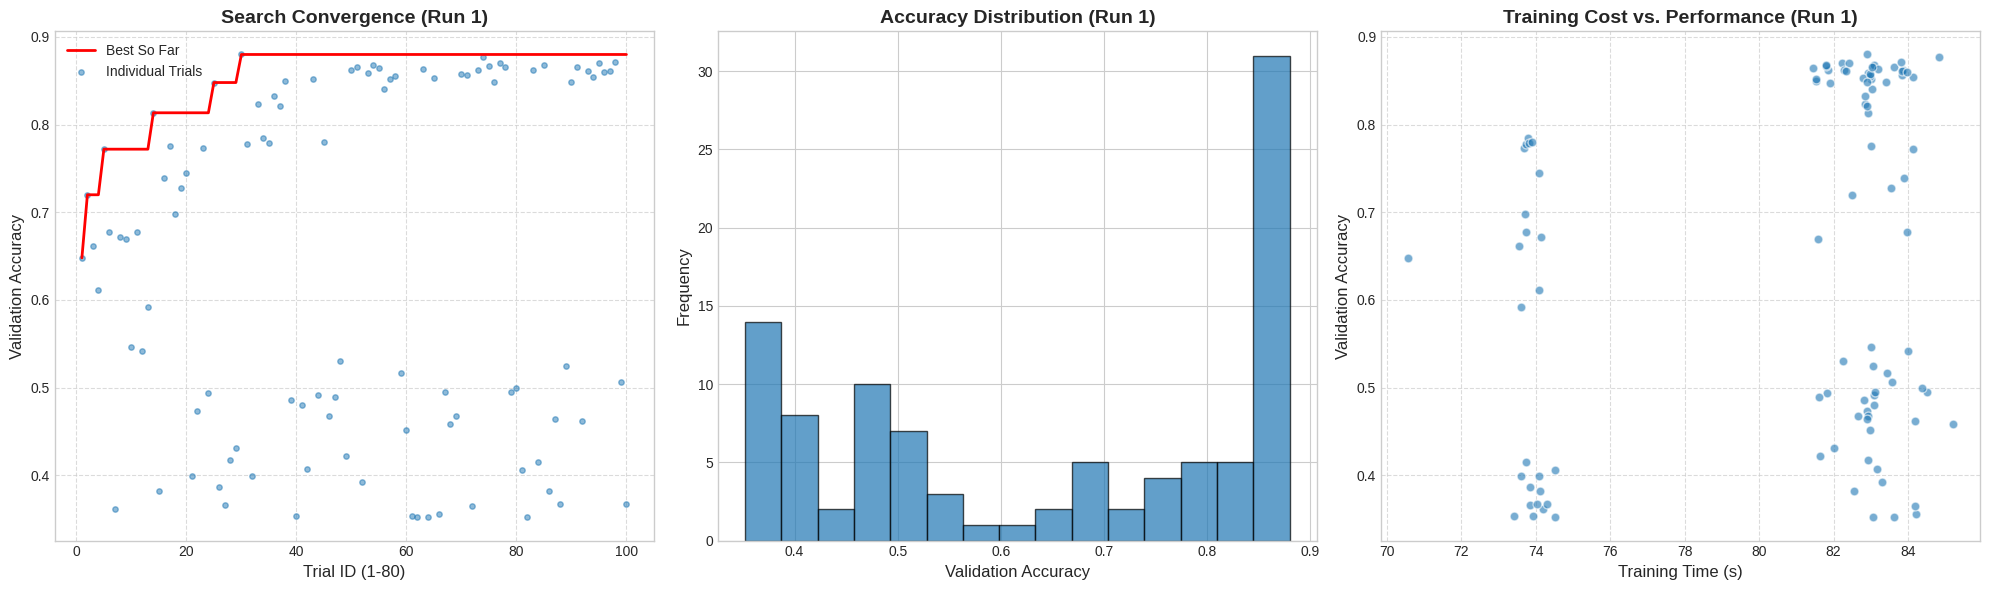

In [14]:
visualize_results()